In [ ]:
import numpy as np
import soundfile as sf

from vkplatejax.excitations import create_1d_raised_cosine
from vkplatejax.ftm import (
    PlateParameters,
    damping_term_simple,
    stiffness_term,
)
from vkplatejax.num_utils import (
    compute_coupling_matrix_numerical,
    multiresolution_eigendecomposition,
)
from vkplatejax.sv import (
    A_inv_vector,
    B_vector,
    C_vector,
    solve_sv_vk_jax_scan,
)

Parameters

In [4]:
params = PlateParameters(
    E=2e12,
    nu=0.3,
    rho=7850,
    h=5e-4,
    l1=0.2,
    l2=0.3,
    Ts0=0,
)

n_modes = 10
sampling_rate = 44100
sampling_period = 1 / sampling_rate
h = 0.004  # grid spacing in the lowest resolution
nx = 50  # number of grid points in the x direction in the lowest resolution
ny = 75  # number of grid points in the y direction in the lowest resolution
levels = 2  # number of grid refinements to perform

# boundary conditions for the transverse modes
bcs_phi = np.array(
    [
        [1e15, 0],
        [1e15, 0],
        [1e15, 0],
        [1e15, 0],
    ]
)

# boundary conditions for the in-plane modes
bcs_psi = np.array(
    [
        [1e15, 1e15],
        [1e15, 1e15],
        [1e15, 1e15],
        [1e15, 1e15],
    ]
)

In [5]:
psi, zeta_mu, nx_final, ny_final, h_final, psi_norms = (
    multiresolution_eigendecomposition(
        params,
        n_modes,
        bcs_psi,
        h,
        nx,
        ny,
        levels=2,
    )
)

phi, lambda_mu, nx_final, ny_final, h_final, phi_norms = (
    multiresolution_eigendecomposition(
        params,
        n_modes,
        bcs_phi,
        h,
        nx,
        ny,
        levels=2,
    )
)

Refining grid to h = 0.002, nx = 100, ny = 150
Refining grid to h = 0.002, nx = 100, ny = 150


In [37]:
H = compute_coupling_matrix_numerical(
    psi,
    phi,
    h_final,
    nx_final,
    ny_final,
)
print(np.diag(H[0]))
e = params.E / (2 * params.rho)
H = H * np.sqrt(e)

[ -285711.54679327  -625265.18692254  -590349.02469367 -1330267.3083214
  -293079.3698046   -355599.78353658 -2339913.84150559 -1276272.86542238
  -456253.19477876  -537877.2092591 ]


In [29]:
# the stiffness here is slightly different because
# we assume always the lambda mu comes from the decomposition of laplacian
k = stiffness_term(params, np.sqrt(lambda_mu))
c = damping_term_simple(np.sqrt(k))
print(f"omega_mu = {np.sqrt(k)}")

omega_mu = [ 860.69610477 1655.09378325 2647.68253544 2978.70274307 3442.08021231
 4765.68917001 4830.94240522 5624.0336986  6418.43137408 6617.9288299 ]


In [30]:
A_inv = A_inv_vector(sampling_period, c * 2)
B = B_vector(sampling_period, k) * A_inv
C = C_vector(sampling_period, c * 2) * A_inv

In [31]:
eigenfunction_norm = 0.25 * params.l1 * params.l2
sampling_factor = (1 / params.density) * A_inv

In [38]:
force_position = (0.05, 0.05)
readout_position = (0.1, 0.1)

# generate a 1d raised cosine excitation
rc = create_1d_raised_cosine(
    duration=2.0,
    start_time=0.010,
    end_time=0.012,
    amplitude=2.0,
    sample_rate=44100,
)


phi_reshaped = np.reshape(
    phi,
    shape=(ny_final + 1, nx_final + 1, n_modes),
    order="F",
)

mode_gains_at_pos = phi_reshaped[
    int(force_position[1] * ny_final),
    int(force_position[0] * nx_final),
    :,
]

mode_gains_at_readout = phi_reshaped[
    int(readout_position[1] * ny_final),
    int(readout_position[0] * nx_final),
    :,
]
# the modal excitation needs to be scaled by A_inv and divided by the density
mode_gains_at_pos_normalised = (mode_gains_at_pos / params.density) * A_inv
modal_excitation_normalised = rc[:, None] * mode_gains_at_pos_normalised

print(modal_excitation_normalised.max(), modal_excitation_normalised.min())

3.6568593770927784e-10 -1.8512587986233105e-10


In [39]:
sampling_factor = A_inv

In [40]:
_, modal_sol = solve_sv_vk_jax_scan(
    A_inv,
    B,
    C,
    modal_excitation_normalised,
    Hv=H,
    g=A_inv,
)

In [41]:
from IPython.display import Audio
from matplotlib import pyplot as plt

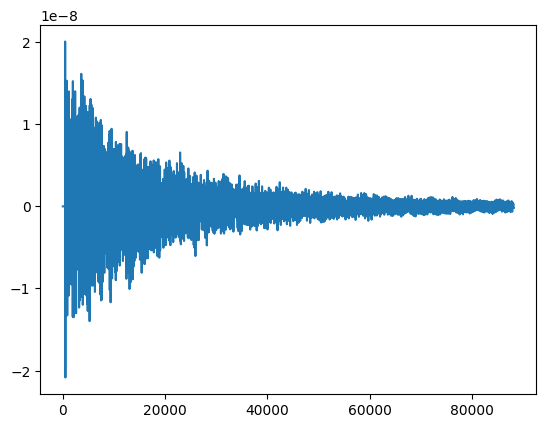

In [42]:
out_vel = modal_sol @ mode_gains_at_readout
out_vel = np.diff(out_vel, axis=0)

plt.plot(out_vel)
display(Audio(out_vel, rate=44100))
sf.write("out_vk_vkplate.wav", out_vel / np.max(out_vel), 44100)